In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
plt.style.use('ggplot')


### Open data same as before

In [3]:
def keep_relevant_set_index(df, relevant_columns):
    """
    Filters the DataFrame to include only the specified columns and sets 1st col as index
    
    Parameters:
    - df: The input DataFrame.
    - relevant_columns: List of column names to keep in the DataFrame.
    
    Returns:
    - A new DataFrame with only the specified columns.
    """
    filtered_df = df[relevant_columns] if all(col in df.columns for col in relevant_columns) else None
    
    if filtered_df is None:
        raise ValueError("One or more columns in 'relevant_columns' do not exist in the DataFrame.")
    filtered_df = filtered_df.set_index(filtered_df.columns[0])

    return filtered_df

In [10]:
def simplify_column(df: pd.DataFrame, column_name: str, mapping_dict: dict):
    """
    Simplifies the values in a specific column based on a mapping dictionary.
    
    Parameters:
    - df: The input DataFrame.
    - column_name: The column to be simplified.
    - mapping_dict: A dictionary where the keys are the current values, 
      and the values are the simplified labels to map to.
    
    Returns:
    - A new DataFrame with the simplified column.
    """
    # Apply the mapping to the column
    df[column_name] = df[column_name].map(mapping_dict).fillna(df[column_name])
    return df

In [11]:
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')

zones_geodata = keep_relevant_set_index(zones_geodata, ["_id" , "GEN_ZONE", "geometry"])

zones_geodata.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define simplified mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utility and Transportation', 
                4: 'Industrial', 5: 'Institutional',
                6: 'Commercial', 101: 'Residential', 
                201: 'Commercial', 202: 'Commercial'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata['Zone_type'] = zones_geodata['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata.head()

Zone_type  \
_id                               
1    Utility and Transportation   
2                    Open Space   
3                   Residential   
4                    Open Space   
5                   Residential   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((-79.20970 43.81729, -79.20961 ...  
2    MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ...  
3    MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ...  
4    MULTIPOLYGON (((-79.57040 43.72175, -79.57042 ...  
5    MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ...

In [12]:
zones_geodata.Zone_type.unique()

array(['Utility and Transportation', 'Open Space', 'Residential',
       'Industrial', 'Commercial', 'Institutional'], dtype=object)

### Plotting zones to compare

In [32]:
def plot_specific_subset(df, name, column, figsize=(10, 8), cmap='Set3'):
    """
    Plots a specific area/subset of data from the GeoDataFrame based on the specified name in col.
    
    Parameters:
    - df: GeoDataFrame containing the data.
    - name: The name or identifier of the area to plot.
    - column: The column used for categorical coloring (default is 'Zone_type').
    - figsize: Size of the plot (default is (10, 8)).
    - cmap: The colormap used for the plot (default is 'Set3').
    
    Returns:
    - Displays a plot of the specified zone.
    """
    # Filter the GeoDataFrame to only include the specified zone
    df = df[df[column] == name]

    # Check if the zone exists in the data
    if df.empty:
        print(f"Area '{name}' not found in the data.")
        return

    # Plotting the specific zone
    fig, ax = plt.subplots(figsize=figsize)

    # Plot with categorical coloring based on 'column' (default is 'Zone_type')
    df.plot(column=column, ax=ax, legend=True, 
                   legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                   cmap=cmap, edgecolor='black')

    # Add labels and title
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(f'{name} Areas', fontsize=16)

    # Display the plot
    plt.show()

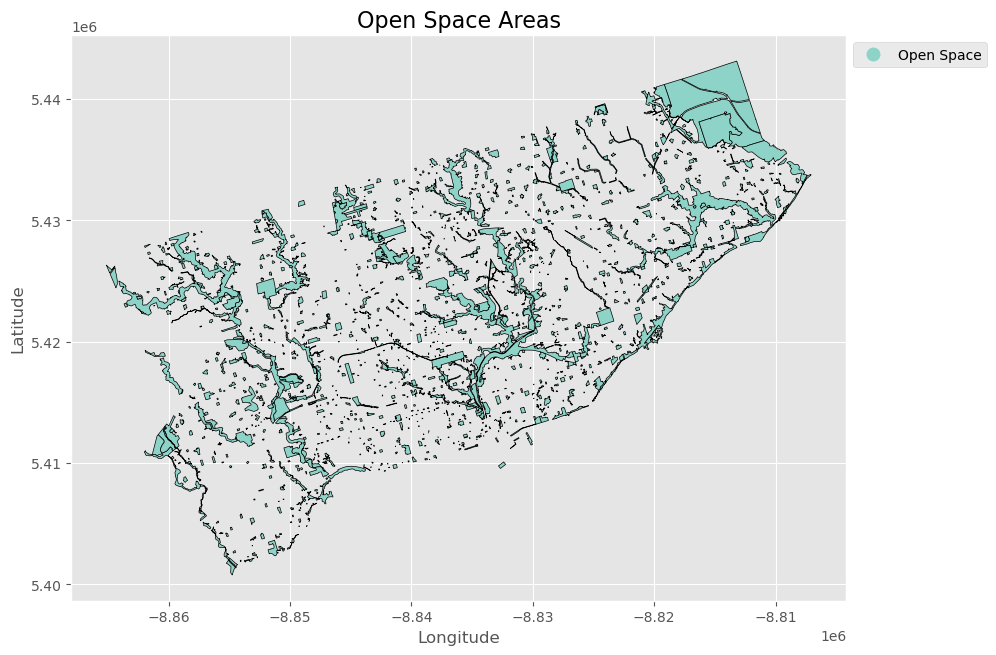

In [68]:
plot_specific_subset(zones_geodata, 'Open Space', 'Zone_type')


### Let's compare this with greenspace dataset

In [23]:
greenspace = gpd.read_file('Green Spaces - 4326.geojson')

greenspace = keep_relevant_set_index(greenspace, ["_id" ,'AREA_CLASS', 'geometry'])
greenspace.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace.head()

Area_type                                           geometry
_id                                                                   
1    OTHER_CEMETERY  MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ...
2    OTHER_CEMETERY  MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ...
3    OTHER_CEMETERY  MULTIPOLYGON (((-79.34758 43.80810, -79.34758 ...
4    OTHER_CEMETERY  MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ...
5    OTHER_CEMETERY  MULTIPOLYGON (((-79.31649 43.79640, -79.31650 ...

In [24]:
greenspace.Area_type.unique()

array(['OTHER_CEMETERY', 'OTHER_CITY', 'OTHER_GOLFCOURSE',
       'OTHER_PROVINCIAL_FEDERAL', 'OTHER_HYDRO', 'OTHER_ROAD',
       'OTHER_TRCA', 'OTHER_UNKNOWN', 'Building Grounds', 'Park',
       'Open Green Space', 'Traffic Island', 'Golf Course', 'Cul de Sac',
       'Hydro Field/Utility Corridor', 'Orphaned Space',
       'Civic Centre Square', 'Boulevard', 'Cemetery'], dtype=object)

In [25]:
greenspace_mapping = {
    'OTHER_CEMETERY': 'Cemetery',
    'OTHER_CITY': 'Other',
    'OTHER_GOLFCOURSE': 'Golf course',
    'OTHER_PROVINCIAL_FEDERAL': 'Other',
    'OTHER_HYDRO': 'Utilities and Transportation',
    'OTHER_ROAD': 'Utilities and Transportation', 
    'OTHER_TRCA': 'Greenspace',
    'OTHER_UNKNOWN': 'Other',
    'Building Grounds': 'Other',
    'Park': 'Greenspace',
    'Open Green Space': 'Greenspace',
    'Traffic Island': 'Utilities and Transportation',
    'Golf Course': 'Golf course',
    'Cul de Sac': 'Utilities and Transportation',
    'Hydro Field/Utility Corridor': 'Utilities and Transportation',
    'Orphaned Space': 'Other', 
    'Civic Centre Square': 'Other',
    'Boulevard': 'Utilities and Transportation',
    'Cemetery': 'Cemetery'
}

# Replace the values in 'Zone_type' column with the mapped names
greenspace['Area_type'] = greenspace['Area_type'].replace(greenspace_mapping)

# Display the first few rows to ensure it worked
greenspace.head()

Area_type                                           geometry
_id                                                             
1    Cemetery  MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ...
2    Cemetery  MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ...
3    Cemetery  MULTIPOLYGON (((-79.34758 43.80810, -79.34758 ...
4    Cemetery  MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ...
5    Cemetery  MULTIPOLYGON (((-79.31649 43.79640, -79.31650 ...

In [34]:
greenspace.Area_type.unique()

array(['Cemetery', 'Other', 'Golf course', 'Utilities and Transportation',
       'Greenspace'], dtype=object)

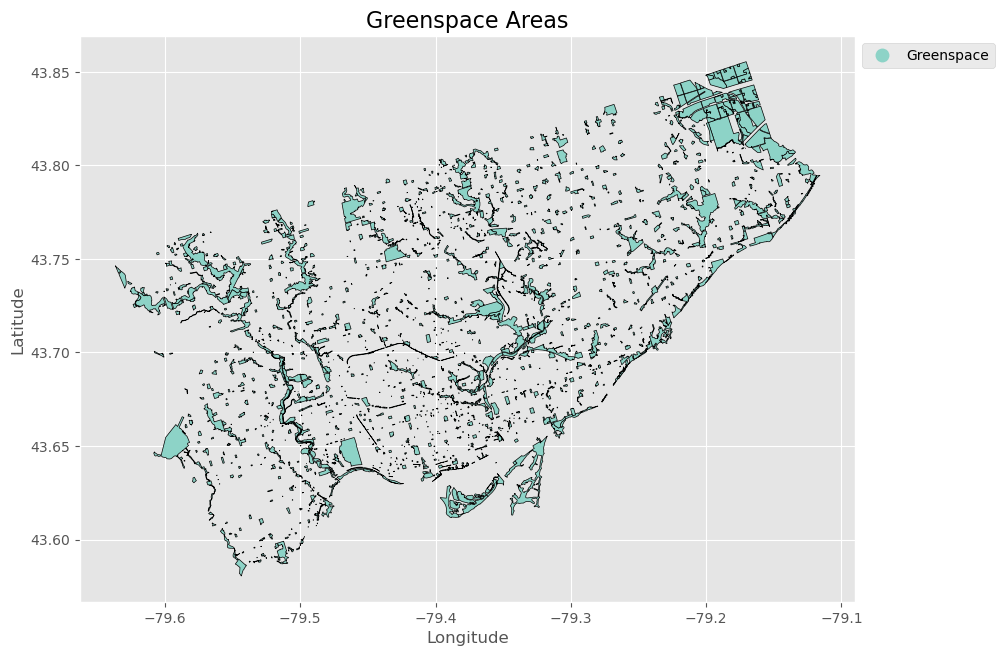

In [70]:
plot_specific_subset(greenspace, 'Greenspace', 'Area_type')


In [73]:
flood_plains = flood_plains.to_crs(epsg=3857)
zones_geodata = zones_geodata.to_crs(epsg=3857)
greenspace = greenspace.to_crs(epsg=3857)

/tmp/ipykernel_52/2936858671.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 10545 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  merged_greenspace = gpd.overlay(greenspace[greenspace['Area_type'] == 'Greenspace'],


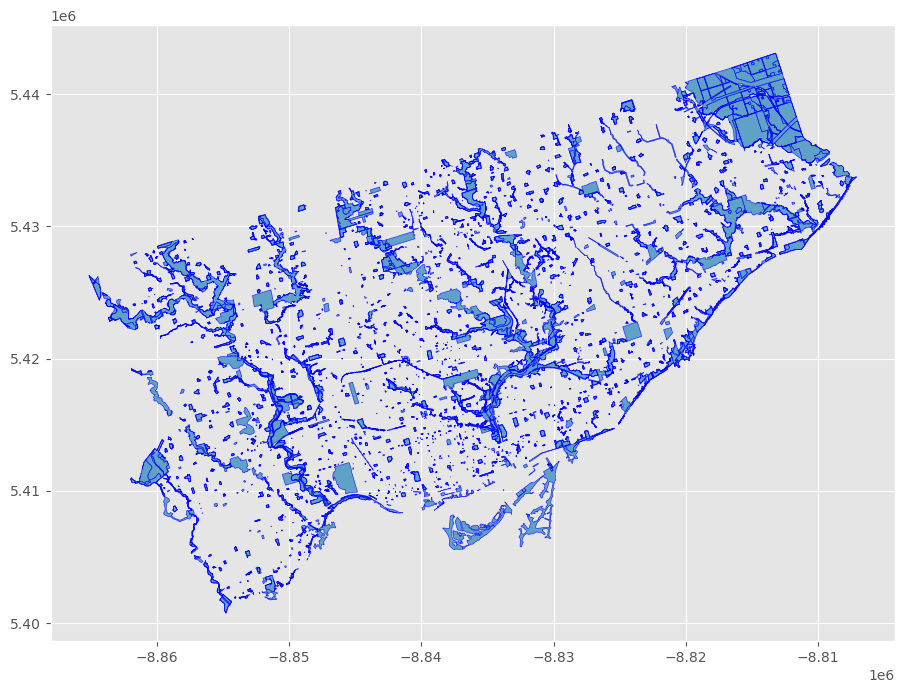

In [75]:
merged_greenspace = gpd.overlay(greenspace[greenspace['Area_type'] == 'Greenspace'], 
                                zones_geodata[zones_geodata['Zone_type'] == 'Open Space'], how='union')

merged_greenspace.plot(figsize=(15, 8), edgecolor='b', alpha=0.75);

In [ ]:
#### zones_geodata, 'Open Space', 'Zone_type')

In [45]:
def plot_specified_elements(gdf1, gdf2, column1, values1, column2, values2, figsize=(10, 8), cmap1='Set3', cmap2='Set2'):
    """
    Plots specified elements from a specific column in each GeoDataFrame on the same plot.

    Parameters:
    - gdf1, gdf2: GeoDataFrames to be plotted.
    - column1, column2: Columns in gdf1 and gdf2 to filter for plotting.
    - values1, values2: Lists of values to be plotted from column1 and column2.
    - figsize: Size of the plot.
    - cmap1, cmap2: Colormap for each GeoDataFrame.
    
    Returns:
    - Displays the plot with filtered elements from both GeoDataFrames.
    """
    # Filter the first GeoDataFrame by the specified values in column1
    gdf1_filtered = gdf1[gdf1[column1].isin(values1)]
    
    # Filter the second GeoDataFrame by the specified values in column2
    gdf2_filtered = gdf2[gdf2[column2].isin(values2)]

    # Create a plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the filtered data from gdf1
    gdf1_filtered.plot(column=column1, ax=ax, legend=True, cmap=cmap1, edgecolor='black', alpha=0.5,
                      legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

#     # Plot the filtered data from gdf2
#     gdf2_filtered.plot(column=column2, ax=ax, legend=True, cmap=cmap2, edgecolor='black', alpha=0.5,
#                       legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

    # Add labels and title
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(f'Filtered Elements from {column1} and {column2}', fontsize=16)

    # Display the plot
    plt.show()

Filtered gdf1 (Area_type): 1742 rows
Filtered gdf2 (Zone_type): 1596 rows


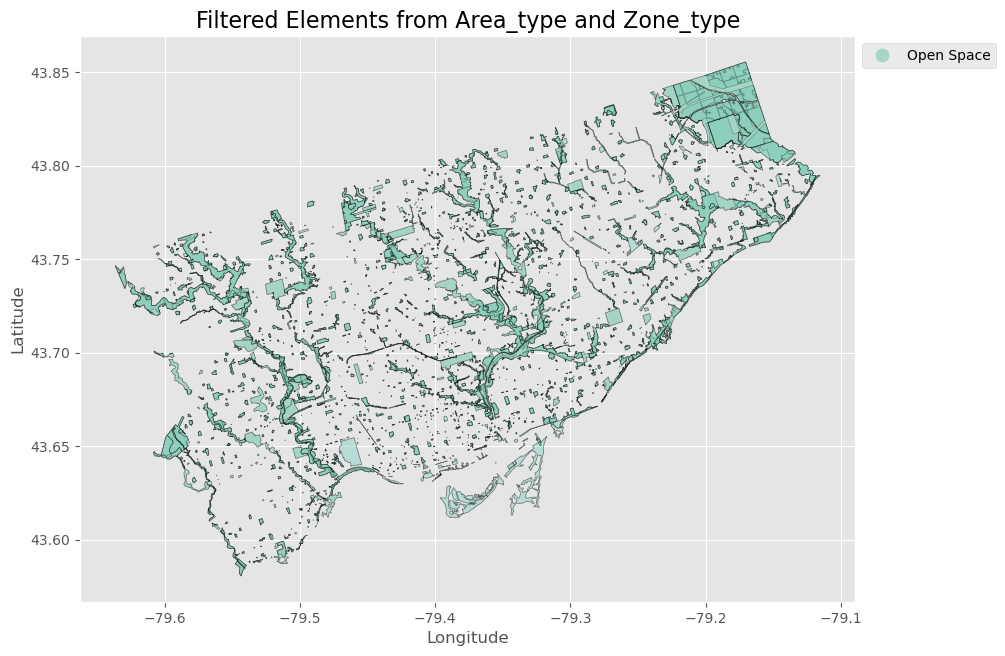

In [46]:
# Create a plot
fig, ax = plt.subplots(figsize=figsize)

# Plot the filtered data from gdf1
gdf1_filtered.plot(column=column1, ax=ax, legend=True, cmap=cmap1, edgecolor='black', alpha=0.5,
                  legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

# Plot the filtered data from gdf2
gdf2_filtered.plot(column=column2, ax=ax, legend=True, cmap=cmap2, edgecolor='black', alpha=0.5,
                  legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

# Add labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'Filtered Elements from {column1} and {column2}', fontsize=16)

# Display the plot
plt.show()

/tmp/ipykernel_52/1649353513.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 168 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection = gpd.overlay(greenspace_filtered, zones_geodata_filtered, how='intersection')


Filtered Greenspace: 1742 rows
Filtered Zones Geodata: 1596 rows
Intersection: 1910 rows


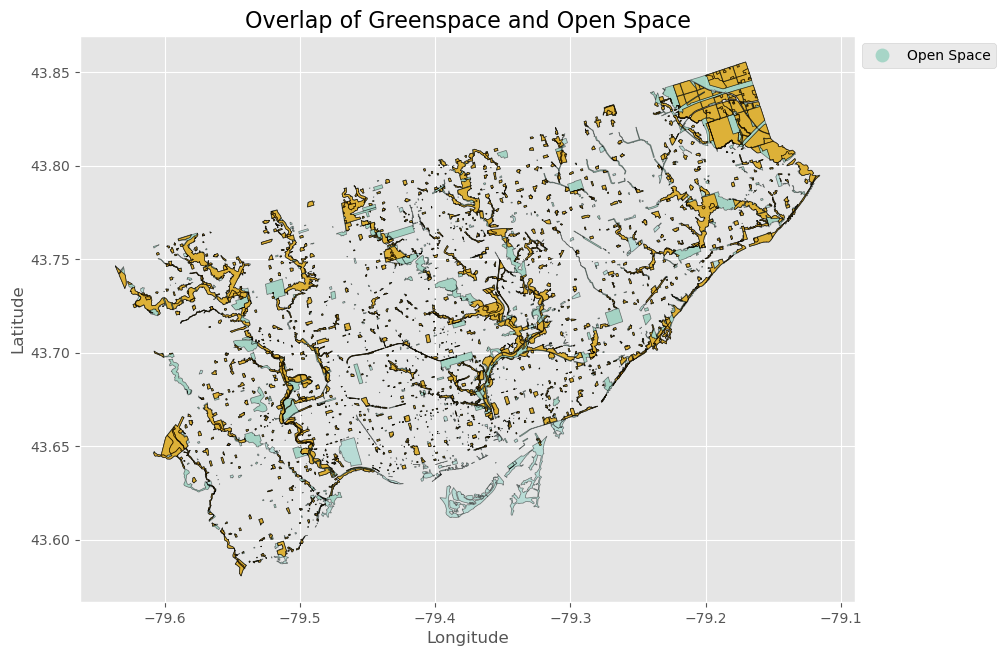

Percentage of Greenspace overlapped with Open Space: 85.57%
Percentage of Open Space overlapped with Greenspace: 68.89%


/tmp/ipykernel_52/1649353513.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  greenspace_overlap = intersection.geometry.area.sum() / greenspace_filtered.geometry.area.sum() * 100
/tmp/ipykernel_52/1649353513.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_geodata_overlap = intersection.geometry.area.sum() / zones_geodata_filtered.geometry.area.sum() * 100


In [58]:
greenspace_filtered = greenspace[greenspace['Area_type'] == 'Greenspace']

# Step 2: Filter zones_geodata for "Open Space"
zones_geodata_filtered = zones_geodata[zones_geodata['Zone_type'] == 'Open Space']

# Step 3: Calculate the intersection of the two filtered GeoDataFrames
intersection = gpd.overlay(greenspace_filtered, zones_geodata_filtered, how='intersection')

# Debugging: Check how many rows are in each dataset and intersection
print(f"Filtered Greenspace: {greenspace_filtered.shape[0]} rows")
print(f"Filtered Zones Geodata: {zones_geodata_filtered.shape[0]} rows")
print(f"Intersection: {intersection.shape[0]} rows")

# Step 4: Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the filtered greenspace (Greenspace)
greenspace_filtered.plot(column='Area_type', ax=ax, legend=True, cmap='Set3', edgecolor='black', alpha=0.5, 
                         legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

# Plot the filtered zones_geodata (Open Space)
zones_geodata_filtered.plot(column='Zone_type', ax=ax, legend=True, cmap='Set2', edgecolor='black', alpha=0.5, 
                            legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'})

# Plot the intersection in a different color (highlighted)
intersection.plot(ax=ax, color='orange', edgecolor='black', alpha=0.7)

# Step 5: Add labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Overlap of Greenspace and Open Space', fontsize=16)

# Display the plot
plt.show()

# Step 6: Calculate the percentage overlap for each GeoDataFrame
greenspace_overlap = intersection.geometry.area.sum() / greenspace_filtered.geometry.area.sum() * 100
zones_geodata_overlap = intersection.geometry.area.sum() / zones_geodata_filtered.geometry.area.sum() * 100

print(f"Percentage of Greenspace overlapped with Open Space: {greenspace_overlap:.2f}%")
print(f"Percentage of Open Space overlapped with Greenspace: {zones_geodata_overlap:.2f}%")

### Brining in flooding data

In [60]:
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])

In [61]:
flood_plains.head()

FloodPlain     Watershed    Shape__Are   Shape__Len  \
OBJECTID                                                        
3394      Engineered     Don River      0.940918     3.803569   
3395      Engineered     Don River    869.856689   149.201240   
3396      Engineered     Don River  23187.910400  1321.226703   
3397      Engineered     Don River  10895.613037   522.001575   
3406      Engineered  Humber River      0.544922     5.605709   

                                                   geometry  
OBJECTID                                                     
3394      MULTIPOLYGON (((-79.36482 43.67112, -79.36482 ...  
3395      MULTIPOLYGON (((-79.38004 43.67332, -79.38004 ...  
3396      MULTIPOLYGON (((-79.37672 43.67350, -79.37671 ...  
3397      MULTIPOLYGON (((-79.37840 43.67362, -79.37840 ...  
3406      MULTIPOLYGON (((-79.50360 43.71073, -79.50360 ...

Intersection: 1415 rows


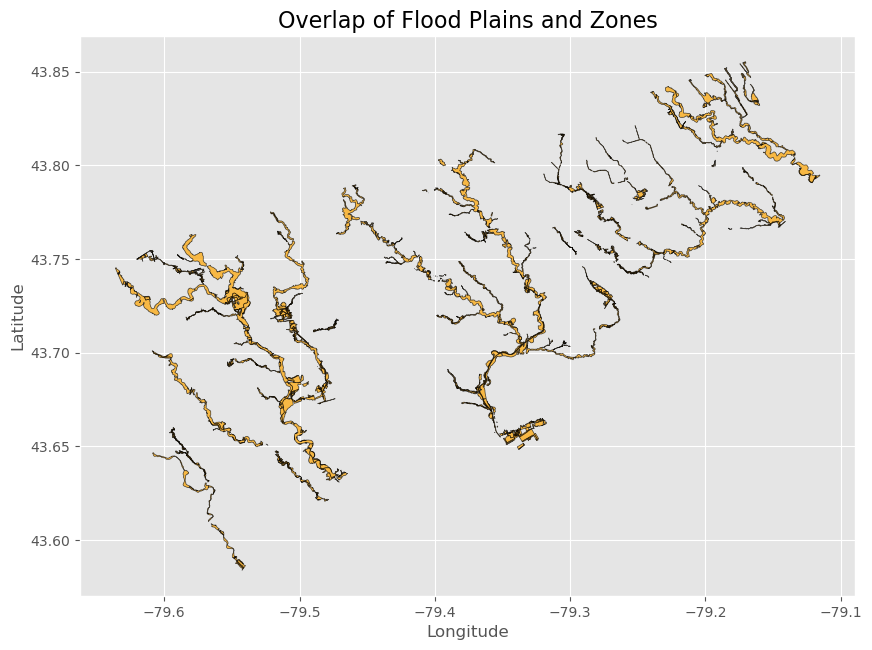

In [63]:
intersection = gpd.overlay(flood_plains, zones_geodata, how='intersection')

# Debugging: Check the number of rows in the intersection
print(f"Intersection: {intersection.shape[0]} rows")

# Step 2: Plotting the zones and the floodplains' intersection
fig, ax = plt.subplots(figsize=(10, 8))


# Plot the intersection in a distinct color (highlighted)
intersection.plot(ax=ax, color='orange', edgecolor='black', alpha=0.7)

# Step 3: Add labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Overlap of Flood Plains and Zones', fontsize=16)

# Display the plot
plt.show()


In [67]:
intersection.head()

FloodPlain  Watershed     Shape__Are   Shape__Len   Zone_type  \
0  Engineered  Don River       0.940918     3.803569  Open Space   
1  Engineered  Don River  399122.425049  5922.625167  Open Space   
2  Engineered  Don River     869.856689   149.201240  Open Space   
3  Engineered  Don River   23187.910400  1321.226703  Open Space   
4  Engineered  Don River   10895.613037   522.001575  Open Space   

                                            geometry  
0  POLYGON ((-8834851.275 5414686.770, -8834851.8...  
1  POLYGON ((-8834685.378 5414589.647, -8834685.6...  
2  POLYGON ((-8836515.967 5414940.848, -8836517.0...  
3  POLYGON ((-8836161.660 5415049.890, -8836161.4...  
4  POLYGON ((-8836362.658 5415072.102, -8836361.9...

In [66]:


intersection = intersection.to_crs(epsg=3857)

zone_overlap_percentage = {}

for zone_id, zone in zones_geodata.iterrows():
    # Select the specific zone geometry
    zone_geometry = zone['geometry']
    
    # Find the intersection of the floodplains with this zone
    zone_intersection = intersection[intersection.geometry.intersects(zone_geometry)]
    
    # If there's an intersection, calculate the percentage overlap
    if not zone_intersection.empty:
        intersection_area = zone_intersection.geometry.area.sum()
        zone_area = zone_geometry.area
        overlap_percentage = (intersection_area / zone_area) * 100
        zone_overlap_percentage[zone['Zone_type']] = overlap_percentage
    else:
        zone_overlap_percentage[zone['Zone_type']] = 'NaN'  # If no intersection

# Step 5: Output the percentage overlap
for zone_type, overlap in zone_overlap_percentage.items():
    if overlap == 'NaN':
        print(f"Zone '{zone_type}': No overlap with flood plains.")
    else:
        print(f"Zone '{zone_type}': {overlap:.2f}% overlap with flood plains.")

Zone 'Utility and Transportation': No overlap with flood plains.
Zone 'Open Space': No overlap with flood plains.
Zone 'Residential': No overlap with flood plains.
Zone 'Industrial': No overlap with flood plains.
Zone 'Commercial': No overlap with flood plains.
Zone 'Institutional': No overlap with flood plains.
